# Overview of co-simulation setup
To run the code, a co-simulation environment has to be setup correctly. It mainly has 3 parts:
- A building model compiled into standard functional mock-up unit (FMU) format
- A OpenAI gym interface wrapper for the FMU
- A reinforcement learning (RL) code to interact with the virtual environment

We created a high-fidelity model of the building with Modelica Buildings Library and then compiled it into a FMU. The lighting, occupant, and plug load schedule were created directly with 1-week measured data. The FMU, schedules and weather file are saved under the same folder (../agent/modelica).

A customized OpenAI gym interface was developed based on Python library - PyFMI (https://github.com/modelon-community/PyFMI). After registering the gym environment, users can interact with the Modelica-based virtual environment using standard OpenAI gym command (refer to: https://gym.openai.com/docs/), such as `env.step`, `env.reset`, etc.

The branching dueling q-network (BDQ) was used as the RL agent to solve the multi-dimensional control task. The original BDQ code is open source (https://github.com/atavakol/action-branching-agents). We mainly modified the `procedure_continuous_tasks.py`, `train_continuous.py` and `enjoy_continuous.py` files and make them work in our virtual environment. 

# Installation
The installation can be troublesome and prone to error. Please feel free to email me if you encounter any problem. The Python version must be 3.6, and we will install PyFMI, tensorflow, OpenAI, and special version of Numpy. I only tested this workflow in Ubuntu but it should also work for other platforms. However, the FMU is platform-specific, meaning that you will need to compile the Modelica model in the Windows FMU format in order to run it in the Windows system.

I include the `requirements.txt` file that listed all the packages I installed on my computer just for your reference.

In [ ]:
#conda create -n BDQ36 python=3.6 # use Anaconda to create a new Python environment called BDQ36
conda create -n BDQ36 python=3.6 --no-default-packages #might be better to exclude additional package, based on python 3.6 

In [ ]:
conda activate BDQ36 # go to the BDQ36 Python environment

In [ ]:
#conda install -c conda-forge pyfmi # install PyFMI via conda forge
conda install -c conda-forge pyfmi=2.8.7 # looks better to declare the version

In [ ]:
pip install tensorflow==1.6.0 # install tensorflow 1.6. The BDQ source code only supports tensorflow 1.x version.

In [ ]:
pip install pandas==1.1.5 # install pandas

In [ ]:
#scipy should be installed with pyFMI
#pip install scipy==1.5.3 # install scipy

In [ ]:
pip install dill==0.3.3 # install dill

In [ ]:
conda install conda-forge::libgfortran4 #install libgfortran

Make sure that `Numpy` is version 1.19.5

In [ ]:
pip install gym==0.9.1 # install older version of gym that supports Python 3.6

# Virtual environment registry
Register our custom environment in OpenAI's gym (refer to: https://stackoverflow.com/questions/52727233/how-can-i-register-a-custom-environment-in-openais-gym). The corresponding code is saved at `../Installation Files`

- Step 1. Go to the Anaconda environment folder (`.../anaconda3/envs/BDQ36/lib/python3.6/site-packages/gym/envs`)
- Step 2. Copy the `modelica` (containing `emulator.py` and `__init__.py`) to the environment folder
- Step 3. Add the following code to the end of the registration file (`.../anaconda3/envs/BDQ36/lib/python3.6/site-packages/gym/envs/_init_.py`). Note that this is NOT the `__init__.py` we just copied.

`
register(
    id='emulator-v0',
    entry_point='gym.envs.modelica:emulator',
    kwargs={'emulator_path':'../bdq/modelica/Beehub_energy.fmu',
            'occ_path':'../agents/bdq/modelica/occ.mos',
            'plug_path':'../agents/bdq/modelica/plug.mos',
            'lgt_path':'../agents/bdq/modelica/lights.mos',
            'weather_path':'../agents/bdq/modelica/SGP_SINGAPORE-CHANGI-AP_486980_18_20.mos',
            'year': 2018,
            'month': 1,
            'day': 1,
            'env_name':'emulator-v0',
            }
)
`

**YOU NEED TO CHANGE ALL THE PATH TO THE CORRESPONDING FILES!**

The weather file contains 3 years Singapore's AMY weather data and starts on 2018-1-1, which is an input for the registeration file.

### Baseline environment (optional)
Register our baseline environment in OpenAI's gym. This is a slightly simplified virtual environment that we only input a fixed temperature setpoint and fan mode.

- Step 1. Go to the Anaconda environment folder (`.../anaconda3/envs/BDQ36/lib/python3.6/site-packages/gym/envs`)
- Step 2. Copy the `modelica_baseline` (containing `emulator_baseline.py` and `__init__.py`) to the environment folder
- Step 3. Add the following code to the end of the registration file (`.../anaconda3/envs/BDQ36/lib/python3.6/site-packages/gym/envs/_init_.py`). Note that this is NOT the `__init__.py` we just copied.

`
register(
    id='emulator-v99',
    entry_point='gym.envs.modelica_baseline:emulator_baseline',
    kwargs={'emulator_path':'../bdq/modelica/Beehub_energy.fmu',
            'occ_path':'../bdq/modelica/occ.mos',
            'plug_path':'../bdq/modelica/plug.mos',
            'lgt_path':'../bdq/modelica/lights.mos',
            'weather_path':'../bdq/modelica/SGP_SINGAPORE-CHANGI-AP_486980_18_20.mos',
            'year': 2018,
            'month': 1,
            'day': 1,
            'env_name':'emulator-v99',
            }
)
`

Now, you should be able to run the co-simulation with the code we provided. Specifically, we can call our custom emulator using `env = gym.make(emulator-v0)`, and call the baseline emulator using `env = gym.make(emulator-v99)`

In [ ]:
cd "../bdq" # go to agent file directory
python offline_train.py # train the BDQ agent for 3 years weather data
python baseline_27.py # run the baseline for 1 year (2020)

The trained weights are saved in .pkl format at `../bdq/trained_models` folder

Other training information, such as rewards, is saved at `../bdq/results` folder

The eight personal comfort matrices used for training is saved at `../agents/bdq-4/ThermalComfort/Initialization`

In [ ]:
cd "../bdq" # go to agent file directory
python online_control.py # run the online control for one step.

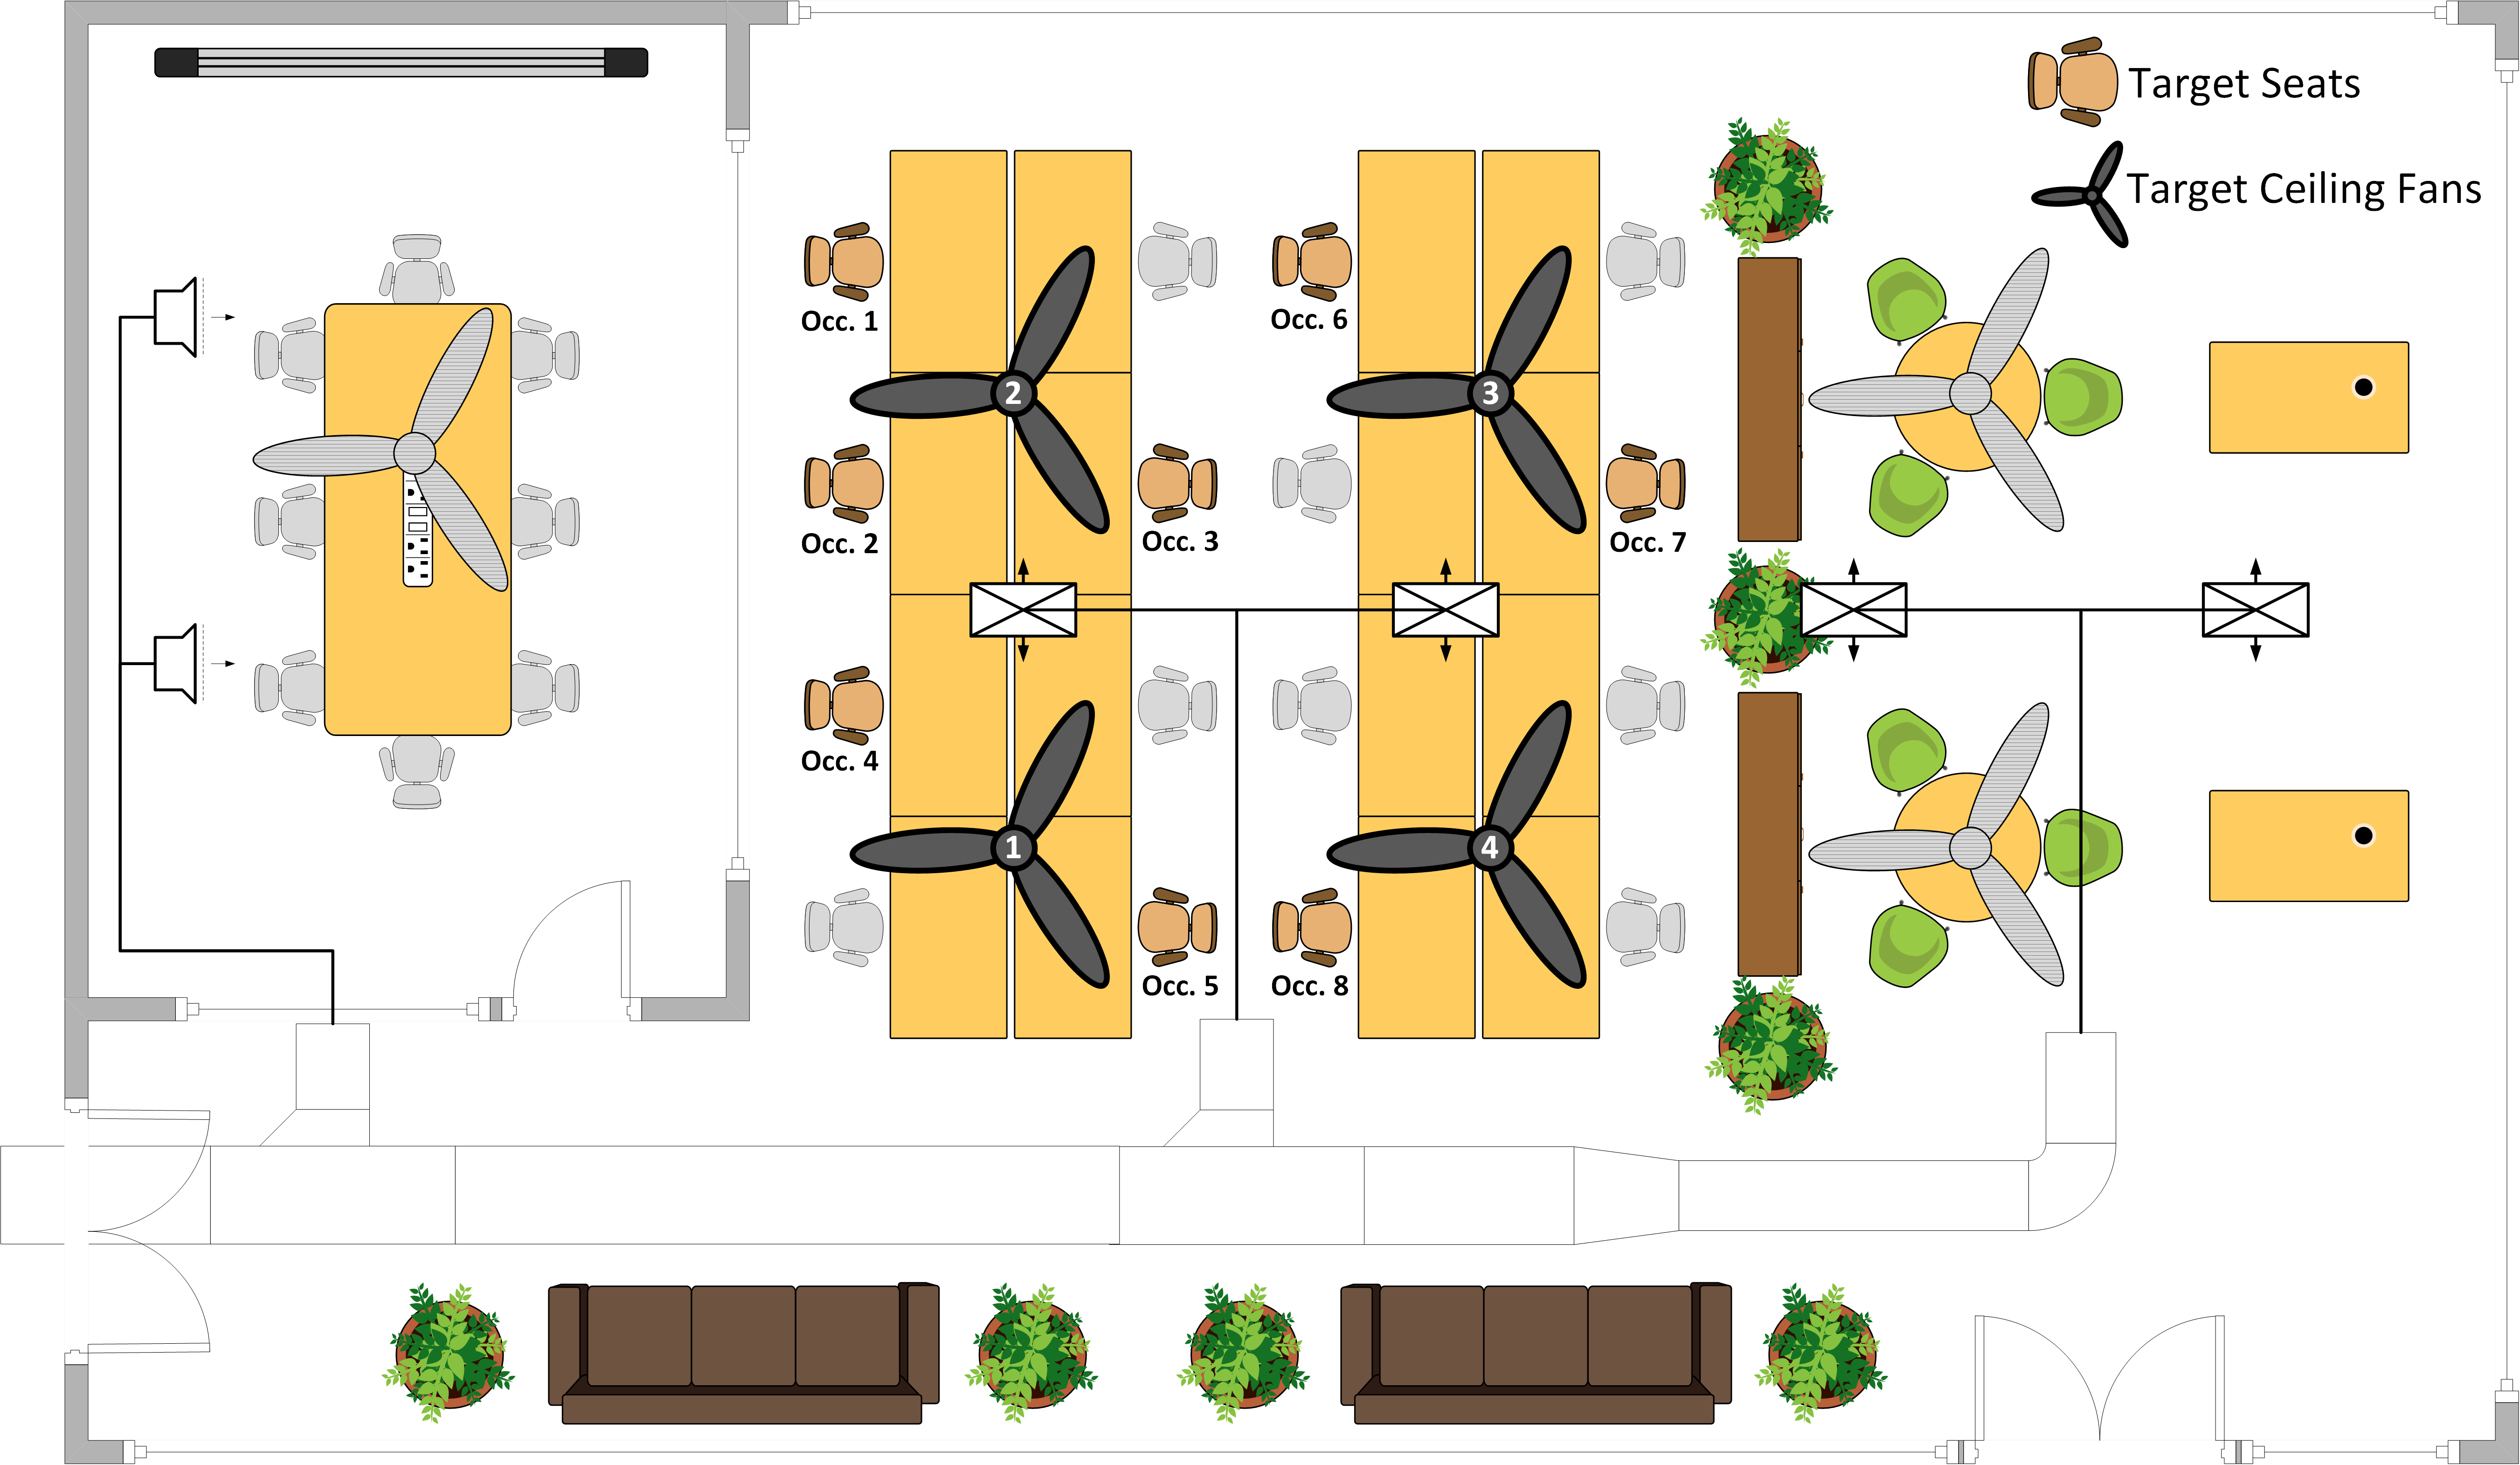
Please refer to this seating plan for the mapping of occupants to corresponding ceiling fan.

# Structure of the code
`offline_train.py` specifies all the parameters for training. It calls `procedure_continuous_tasks.py` in `../bdq/deepq` folder to execute the training. Specifically, `procedure_continuous_tasks.py` creates the deep neural network as the agent and updates the weights for training using `models.py` and `build_graph.py`. Finally, the agent is saved via `dill` function. Note that the occupancy presence is defined as a 1x8 vector `occStatus`, in which 1 is for present and 0 is for not present. Each agent is corresponding to a specific occupancy presence.

To use the agent for online control, `online_control.py` loads the .pkl file. In the script, you need to specify the trainied policy to be put in charge, and input the state variables. It will choose the optimal actions for the temperature setpoint and the mode for four ceiling fans.

# Limitations of the code
- For a more complete solution, we will need to consider the occupance presence info as the state input. However, the total number of states will increase exponentially if we use the basic one-hot encoding, which will inevitably drastically increase the training time. Hence, we need to explore effective approach to encode the occupance presence in the state.
- The update of the personal comfort matrix was done manually based on the comfort survey. However, this process should be automated. Since the agent tries to avoid large penalties (small rewards), only very narrow sets of actions will be chosen. Consequently, it's better for us to update multiple entries of the matrix at once to accelerate the update. For example, if a person feels 28C & M4 is too breezy, we can add additional penalty to all entries with M4, not just the 28C & M4 combination.
- The RL code will not turn off the ceiling fan when there is no one under it, because the ceiling fan uses too little energy to affect the reward calculation. A random fan mode action will be chosen, which we have manually set to M0 in the experiment.

# Other thoughts
Since there is few examples, the Modelica model is difficult to build. As past RL research has suggested, the virtual environment does not have to be very accurate, as pretrained policies will be further improved when interacting with the real environment. Personally I think a calibrated EnergyPlus model should perform similarly in this task. We selected Modelica because it inherently models the building control dynamics without relying on additional software or scripts. So it may lead to better control performance after pre-training for systems with slow-moving dynamics or large time delays.

If considering an EnergyPlus based virtual environment, there are easier ways to create an OpenAI interface wrapper. For example, the Gym-Eplus package (https://github.com/zhangzhizza/Gym-Eplus) is used by many studies.